In [30]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  # Declare batch size

# Define paths
train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

# Define the emotion labels from the file names
uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}


import pandas as pd

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  # Extract emotion class from filename
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = TFSMLayer(pretrained_model)(inputs)

    # Define the output layer
    outputs = layers.Dense(len(uc_label2id), dtype='float32', activation=None)(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Reduced learning rate to avoid OOM issues
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training without jit_scope
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-11-05 12:34:17,548 - INFO - generated new fontManager
2024-11-05 12:34:18.331166: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 12:34:19,906 - INFO - Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: A100-SXM4-40GB MIG 0g.10gb, compute capability 8.0
2024-11-05 12:34:20,068 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2024-11-05 12:34:20.051518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8048 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 0g.10gb, pci bus id: 0000:b7:

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 2406 (9.40 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-05 12:34:34.070479: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 666
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

Epoch 1/50


2024-11-05 12:34:34.281880: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1794] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2024-11-05 12:34:40,535 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-11-05 12:34:40,538 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-11-05 12:34:40,541 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-11-0

166/166 [==============================] - ETA: 0s - loss: 1.8368 - acc@1: 0.2169 - acc: 0.5979

2024-11-05 12:36:23.312239: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 222
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

166/166 [==============================] - 144s 752ms/step - loss: 1.8368 - acc@1: 0.2169 - acc: 0.5979 - val_loss: 1.8087 - val_acc@1: 0.2364 - val_acc: 0.5818
Epoch 2/50
166/166 [==============================] - 127s 762ms/step - loss: 1.7046 - acc@1: 0.2801 - acc: 0.6777 - val_loss: 1.6971 - val_acc@1: 0.3273 - val_acc: 0.6455
Epoch 3/50
166/166 [==============================] - 124s 745ms/step - loss: 1.6285 - acc@1: 0.3328 - acc: 0.6883 - val_loss: 1.6818 - val_acc@1: 0.3182 - val_acc: 0.6500
Epoch 4/50
166/166 [==============================] - 131s 786ms/step - loss: 1.5677 - acc@1: 0.3524 - acc: 0.7425 - val_loss: 1.6614 - val_acc@1: 0.3136 - val_acc: 0.6864
Epoch 5/50
166/166 [==============================] - 116s 697ms/step - loss: 1.5443 - acc@1: 0.3840 - acc: 0.7515 - val_loss: 1.6006 - val_acc@1: 0.3727 - val_acc: 0.7182
Epoch 6/50
166/166 [==============================] - 123s 735ms/step - loss: 1.5126 - acc@1: 0.3825 - acc: 0.7801 - val_loss: 1.5873 - val_acc@1: 0.38

In [31]:
evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")


2024-11-05 14:14:00.669463: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 228
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

57/57 [==============================] - 39s 633ms/step - loss: 1.3231 - acc@1: 0.4430 - acc: 0.8333
Accuracy: 0.8333333134651184
Top-3 Accuracy: 0.4429824650287628


In [32]:
!pip install seaborn scikit-learn


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.9 MB/s eta 0:00:00 0:00:01


1/1 [==============================] - 0s 231ms/step


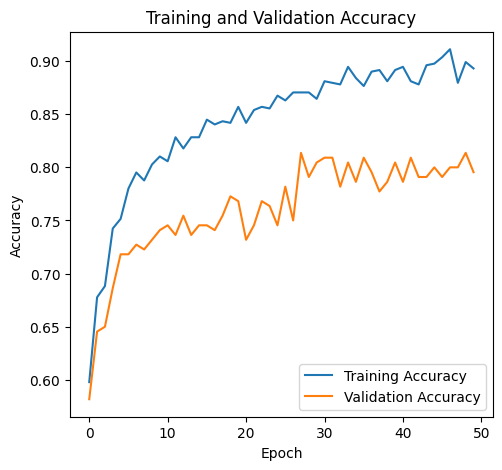

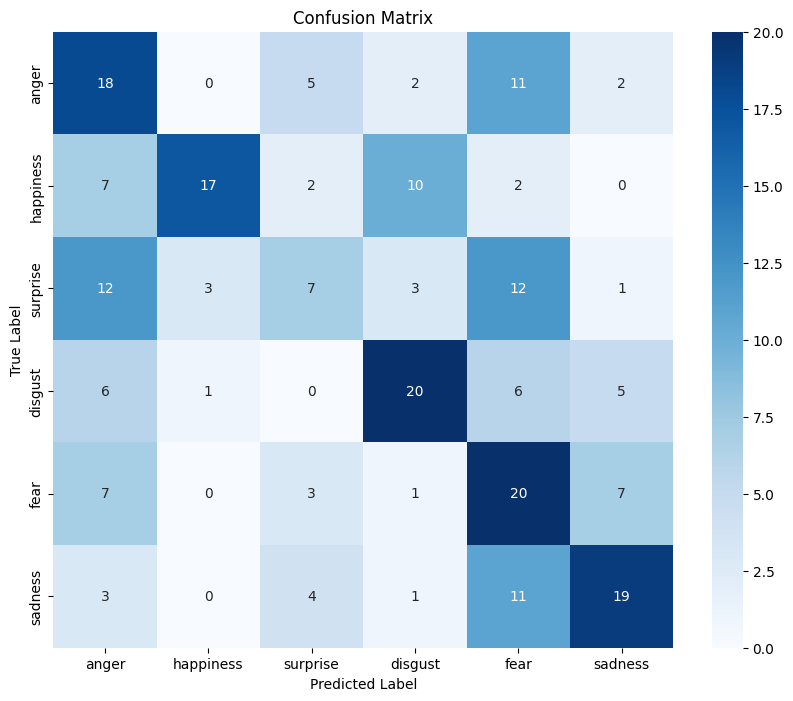

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Plot accuracy and loss for training and validation
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    


# Call the function to plot accuracy and loss
plot_training_history(history)

# Generate predictions and plot confusion matrix
def plot_confusion_matrix(model, dataset, label_mapping):
    # Generate predictions
    y_true = []
    y_pred = []
    
    for videos, labels in dataset:
        predictions = model.predict(videos)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=list(label_mapping.keys()))
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, test_uc_ds, uc_label2id)


In [38]:
print('end')

end


In [42]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  # Declare batch size

# Define paths
train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

# Define the emotion labels from the file names
uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}



import pandas as pd

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  # Extract emotion class from filename
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Define the processing model
processing_model = keras.Sequential([
    layers.Rescaling(scale=1./255.),
    layers.Normalization()
])

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = TFSMLayer(pretrained_model)(inputs)

    # Normalize the output using the processing model
    x = processing_model(x)  # Apply normalization here

    # Define the output layer
    outputs = layers.Dense(len(uc_label2id), dtype='float32', activation=None)(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Reduced learning rate to avoid OOM issues
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training without jit_scope
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-11-05 14:53:23,949 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer_2 (TFSMLayer)    (None, 400)               0         
                                                                 
 sequential_1 (Sequential)   (None, 400)               801       
                                                                 
 dense_1 (Dense)             (None, 6)                 2406      
                                                                 
Total params: 3207 (10.97 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 801 (1.57 KB)
_________________________________________________________________


2024-11-05 14:53:37.096552: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 666
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:4597"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

Epoch 1/50


2024-11-05 14:53:54.882100: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6407_impl', 164 bytes spill stores, 164 bytes spill loads



166/166 [==============================] - ETA: 0s - loss: 1.7925 - acc@1: 0.1461 - acc: 0.4669

2024-11-05 14:55:44.949921: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 222
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:4602"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

166/166 [==============================] - 164s 711ms/step - loss: 1.7925 - acc@1: 0.1461 - acc: 0.4669 - val_loss: 1.7911 - val_acc@1: 0.2227 - val_acc: 0.5227
Epoch 2/50
166/166 [==============================] - 119s 710ms/step - loss: 1.7910 - acc@1: 0.2003 - acc: 0.5467 - val_loss: 1.7903 - val_acc@1: 0.2455 - val_acc: 0.5955
Epoch 3/50
166/166 [==============================] - 121s 724ms/step - loss: 1.7899 - acc@1: 0.2590 - acc: 0.6039 - val_loss: 1.7895 - val_acc@1: 0.2409 - val_acc: 0.5773
Epoch 4/50
166/166 [==============================] - 120s 713ms/step - loss: 1.7888 - acc@1: 0.2425 - acc: 0.6009 - val_loss: 1.7888 - val_acc@1: 0.2591 - val_acc: 0.5500
Epoch 5/50
166/166 [==============================] - 122s 732ms/step - loss: 1.7876 - acc@1: 0.2620 - acc: 0.6355 - val_loss: 1.7880 - val_acc@1: 0.2500 - val_acc: 0.5818
Epoch 6/50
166/166 [==============================] - 121s 725ms/step - loss: 1.7865 - acc@1: 0.2726 - acc: 0.6506 - val_loss: 1.7873 - val_acc@1: 0.27

In [43]:
evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")


2024-11-05 16:32:26.662818: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 228
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:4606"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

57/57 [==============================] - 34s 588ms/step - loss: 1.7538 - acc@1: 0.3202 - acc: 0.7018
Accuracy: 0.7017543911933899
Top-3 Accuracy: 0.320175439119339


In [49]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync  # Declare batch size

# Define paths
train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

# Define the emotion labels from the file names
uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}

import pandas as pd
def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  # Extract emotion class from filename
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    video_path = file_path.numpy().decode('utf-8')  # Decode path outside of TensorFlow function
    vr = VideoReader(video_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    return video, tf.cast(label, dtype=tf.float32)

def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples - 1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)

def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips * num_frames, crop_size, crop_size, 3]
    )
    return video



normalization_layer = layers.Normalization()
normalization_layer.build(input_shape=(None, 400))  # Adjust input shape as necessary
normalization_layer.set_weights([
    np.array([0.485, 0.456, 0.406]),
    np.array([0.225**2, 0.225**2, 0.225**2])
])

processing_model = keras.Sequential([
    layers.Rescaling(scale=1. / 255.),
    normalization_layer
])



def create_dataloader(df, batch_size, shuffle=True, drop_remainder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = TFSMLayer(pretrained_model)(inputs)

    # Ensure the output is properly shaped for normalization
    x = tf.reshape(x, (-1, x.shape[-1]))  # Flatten the last dimension if necessary

    # Normalize the output using the processing model
    x = processing_model(x)  # Apply normalization here

    # Reshape back for the dense layer if necessary
    x = tf.reshape(x, (-1, num_frame, input_size, input_size, 3))  # Reshape as per your requirement

    # Define the output layer
    outputs = layers.Dense(len(uc_label2id), activation='softmax')(x)  # Use softmax for multi-class

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Reduced learning rate to avoid OOM issues
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Match with softmax
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training without jit_scope
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-11-05 16:40:18,479 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


ValueError: You called `set_weights(weights)` on layer "normalization_4" with a weight list of length 2, but the layer was expecting 3 weights. Provided weights: [array([0.485, 0.456, 0.406]), array([0.050625, 0....

In [51]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd_device in device_name:
        tf.config.experimental.set_memory_growth(pd_device, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync  # Declare batch size

# Define paths
train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

# Define the emotion labels from the file names
uc_label2id = {
    'anger': 0,
    'happiness': 1,
    'surprise': 2,
    'disgust': 3,
    'fear': 4,
    'sadness': 5
}
uc_id2label = {v: k for k, v in uc_label2id.items()}

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            parts = video_file.split('_')
            if len(parts) > 1:
                emotion = parts[1]  # Extract emotion class from filename
                if emotion in uc_label2id:
                    video_path = os.path.join(path, video_file)
                    data.append({
                        'video_path': os.path.abspath(video_path),
                        'label': uc_label2id[emotion],
                        'class_name': emotion
                    })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    video_path = file_path.numpy().decode('utf-8')  # Decode path outside of TensorFlow function
    vr = VideoReader(video_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    label = tf.cast(label, dtype=tf.float32)
    return video, label

def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples - 1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)

def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips * num_frames, crop_size, crop_size, 3]
    )
    return video

def create_dataloader(df, batch_size, shuffle=True, drop_remainder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)








# Define the normalization layer with mean and variance
normalization_layer = layers.Normalization(
    mean=[0.485, 0.456, 0.406], 
    variance=[0.225**2, 0.225**2, 0.225**2]
)

# Define the processing model
processing_model = keras.Sequential([
    layers.Rescaling(scale=1. / 255.),
    layers.TimeDistributed(normalization_layer)
])








# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        # Adjust the input key based on your model's signature
        outputs = self.model.signatures['serving_default'](input_1=inputs)['output_1']
        return outputs

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = processing_model(inputs)  # Apply Rescaling and Normalization
    x = TFSMLayer(pretrained_model)(x)  # Pass to pre-trained model
    # Assuming TFSMLayer outputs (batch_size, feature_dim), e.g., (batch_size, 400)
    outputs = layers.Dense(len(uc_label2id), activation='softmax')(x)  # Use softmax for multi-class

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Adjust as necessary
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Match with softmax
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-11-05 16:42:11,849 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 sequential_4 (Sequential)   (None, 16, 224, 224, 3)   0         
                                                                 
 tfsm_layer_5 (TFSMLayer)    (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 2406      
                                                                 
Total params: 2406 (9.40 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-05 16:42:27.497991: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 666
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:5420"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.8407 - acc@1: 0.1581 - acc: 0.4819

2024-11-05 16:44:14.565499: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 222
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:5425"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

83/83 [==============================] - 142s 1s/step - loss: 1.8407 - acc@1: 0.1581 - acc: 0.4819 - val_loss: 1.7996 - val_acc@1: 0.1574 - val_acc: 0.5139
Epoch 2/50
83/83 [==============================] - 123s 1s/step - loss: 1.8109 - acc@1: 0.1958 - acc: 0.5120 - val_loss: 1.8063 - val_acc@1: 0.1667 - val_acc: 0.5046
Epoch 3/50
83/83 [==============================] - 123s 1s/step - loss: 1.8189 - acc@1: 0.1627 - acc: 0.5030 - val_loss: 1.7908 - val_acc@1: 0.1806 - val_acc: 0.5139
Epoch 4/50
83/83 [==============================] - 121s 1s/step - loss: 1.8215 - acc@1: 0.1551 - acc: 0.5015 - val_loss: 1.8057 - val_acc@1: 0.1667 - val_acc: 0.5139
Epoch 5/50
83/83 [==============================] - 120s 1s/step - loss: 1.8033 - acc@1: 0.1777 - acc: 0.5166 - val_loss: 1.7879 - val_acc@1: 0.1806 - val_acc: 0.5463
Epoch 6/50
83/83 [==============================] - 130s 2s/step - loss: 1.8110 - acc@1: 0.1431 - acc: 0.5196 - val_loss: 1.8013 - val_acc@1: 0.1898 - val_acc: 0.5000
Epoch 7/5

In [52]:
evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")


2024-11-05 18:23:59.905157: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 228
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:5429"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

28/28 [==============================] - 30s 1s/step - loss: 1.7999 - acc@1: 0.2098 - acc: 0.5268
Accuracy: 0.5267857313156128
Top-3 Accuracy: 0.2098214328289032


In [53]:
print('ende')

ende


In [54]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd_device in device_name:
        tf.config.experimental.set_memory_growth(pd_device, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync  # Declare batch size

# Define paths
train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

# Define the emotion labels from the file names
uc_label2id = {
    'anger': 0,
    'happiness': 1,
    'surprise': 2,
    'disgust': 3,
    'fear': 4,
    'sadness': 5
}
uc_id2label = {v: k for k, v in uc_label2id.items()}

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            parts = video_file.split('_')
            if len(parts) > 1:
                emotion = parts[1]  # Extract emotion class from filename
                if emotion in uc_label2id:
                    video_path = os.path.join(path, video_file)
                    data.append({
                        'video_path': os.path.abspath(video_path),
                        'label': uc_label2id[emotion],
                        'class_name': emotion
                    })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    video_path = file_path.numpy().decode('utf-8')  # Decode path outside of TensorFlow function
    vr = VideoReader(video_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    label = tf.cast(label, dtype=tf.float32)
    return video, label

def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples - 1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)

def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips * num_frames, crop_size, crop_size, 3]
    )
    return video



# Define the normalization layer with mean and variance
normalization_layer = layers.Normalization(
    mean=[0.485, 0.456, 0.406], 
    variance=[0.225**2, 0.225**2, 0.225**2]
)

# Define the processing model
processing_model = keras.Sequential([
    layers.Rescaling(scale=1. / 255.),
    layers.TimeDistributed(normalization_layer)
])




def create_dataloader(df, batch_size, shuffle=True, drop_remainder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)




# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        # Adjust the input key based on your model's signature
        outputs = self.model.signatures['serving_default'](input_1=inputs)['output_1']
        return outputs

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = processing_model(inputs)  # Apply Rescaling and Normalization
    x = TFSMLayer(pretrained_model)(x)  # Pass to pre-trained model
    # Assuming TFSMLayer outputs (batch_size, feature_dim), e.g., (batch_size, 400)
    outputs = layers.Dense(len(uc_label2id), activation='softmax')(x)  # Use softmax for multi-class

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Adjust as necessary
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Match with softmax
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-11-05 21:33:26,902 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 sequential_5 (Sequential)   (None, 16, 224, 224, 3)   0         
                                                                 
 tfsm_layer_6 (TFSMLayer)    (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 2406      
                                                                 
Total params: 2406 (9.40 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-05 21:33:43.504245: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 666
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:6204"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.8261 - acc@1: 0.1657 - acc: 0.4654

2024-11-05 21:35:38.007778: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 222
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:6209"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

83/83 [==============================] - 153s 2s/step - loss: 1.8261 - acc@1: 0.1657 - acc: 0.4654 - val_loss: 1.8029 - val_acc@1: 0.1667 - val_acc: 0.5370
Epoch 2/50
83/83 [==============================] - 124s 1s/step - loss: 1.8124 - acc@1: 0.1958 - acc: 0.4864 - val_loss: 1.8720 - val_acc@1: 0.1667 - val_acc: 0.4907
Epoch 3/50
83/83 [==============================] - 118s 1s/step - loss: 1.8228 - acc@1: 0.1657 - acc: 0.4955 - val_loss: 1.8087 - val_acc@1: 0.1667 - val_acc: 0.5093
Epoch 4/50
83/83 [==============================] - 127s 2s/step - loss: 1.8104 - acc@1: 0.1672 - acc: 0.4985 - val_loss: 1.8046 - val_acc@1: 0.1852 - val_acc: 0.5139
Epoch 5/50
83/83 [==============================] - 123s 1s/step - loss: 1.7944 - acc@1: 0.1943 - acc: 0.5467 - val_loss: 1.8248 - val_acc@1: 0.1667 - val_acc: 0.5231
Epoch 6/50
83/83 [==============================] - 126s 2s/step - loss: 1.8056 - acc@1: 0.1777 - acc: 0.5226 - val_loss: 1.8092 - val_acc@1: 0.1944 - val_acc: 0.5000
Epoch 7/5

In [55]:
evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")


2024-11-05 23:16:44.260646: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 228
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:6213"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

28/28 [==============================] - 30s 1s/step - loss: 1.7825 - acc@1: 0.1830 - acc: 0.6027
Accuracy: 0.6026785969734192
Top-3 Accuracy: 0.1830357164144516
